## The goal of Decision Tree is to create a model that predicts the value of a target variable by learning simple decision rules inferred from the data features. 

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.feature_selection import SequentialFeatureSelector, RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, explained_variance_score

In [2]:
outliers_df = pd.read_csv('outliers.csv')
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2353 non-null   float64
 1   bath            2353 non-null   float64
 2   acre_lot        2353 non-null   float64
 3   zip_code        2353 non-null   float64
 4   house_size      2353 non-null   float64
 5   prev_sold_date  2353 non-null   object 
 6   price           2353 non-null   float64
dtypes: float64(6), object(1)
memory usage: 128.8+ KB


#### Create new feature prev_sold_year from prev_sold_date

In [4]:
outliers_df["prev_sold_year"] = pd.to_datetime(outliers_df["prev_sold_date"], format='%Y-%m-%d').dt.year
outliers_df.drop(columns=["prev_sold_date"],inplace=True)
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   bed             2353 non-null   float64
 1   bath            2353 non-null   float64
 2   acre_lot        2353 non-null   float64
 3   zip_code        2353 non-null   float64
 4   house_size      2353 non-null   float64
 5   price           2353 non-null   float64
 6   prev_sold_year  2353 non-null   int64  
dtypes: float64(6), int64(1)
memory usage: 128.8 KB


#### Read the file containing Latitude and Longitude

In [5]:
zip_lon_lat = pd.read_csv('pa_zip-lon-lat.csv')
zip_lon_lat.head()

,Unnamed: 0,zip_code,latitude,longitude
0,0,16914,41.854230,-76.783664
1,1,16925,41.948556,-76.783808
2,3,18013,40.848762,-75.177293
3,45,18077,40.570065,-75.237114
4,102,18301,41.042703,-75.175581


#### Merge the Lat/Long data with the housing data using Zip Code

In [6]:
merged_df = pd.merge(outliers_df, zip_lon_lat, how='inner', on="zip_code")
merged_df.tail()

,bed,bath,acre_lot,zip_code,house_size,price,prev_sold_year,Unnamed: 0,latitude,longitude
2348,3.0,3.0,2.75,18470.0,1913.0,349999.0,2020,187,41.724706,-75.535516
2349,3.0,2.0,4.55,18470.0,1152.0,59000.0,2021,187,41.724706,-75.535516
2350,2.0,2.0,0.05,18421.0,1946.0,85000.0,2022,149,41.664210,-75.492886
2351,2.0,1.0,0.17,18472.0,471.0,98500.0,2021,189,41.583410,-75.396687
2352,3.0,2.0,0.21,18821.0,1175.0,114500.0,2020,253,41.989756,-75.722751


#### Create common variables to store frequently used values.

In [7]:
features = ["latitude","longitude","bed","bath","house_size","prev_sold_year"]
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [8]:
X = merged_df[features]
y = merged_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [9]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [10]:
def print_more_stuff(title, y_param, predict_param, gscv):
    results_dict["model"].append(title)
    
    evs = "{:.9f}".format(explained_variance_score(y_param,predict_param))
    mae = "{:,.6f}".format(mean_absolute_error(y_param,predict_param))
    mse = "{:,.6f}".format(mean_squared_error(y_param,predict_param))
    r2 = "{:,.6f}".format(r2_score(y_param,predict_param))
    
    #find_best_params = gscv.cv_results_["params"].index(gscv.best_params_)
    #mean_fit_time = gscv.cv_results_["mean_fit_time"][find_best_params]
    mean_fit_time = gscv.cv_results_["mean_fit_time"][gscv.best_index_]
    
    results_dict["explained variance score"].append(evs)
    results_dict["mae score"].append(mae)
    results_dict["mse score"].append(mse)
    results_dict["r2 score"].append(r2)
    results_dict["mean fit time"].append(mean_fit_time)
    
    print(title + " EVS = " + evs)
    print(title + " MSE = " + mse)
    print(title + " MAE = " + mae)
    print(title + " R2 = " + r2)
    print(title + " Fit Time = " + str(mean_fit_time))

### GridSearchCV exhaustively generates candidates from a grid of parameter values specified.

In [11]:
params = {'max_depth': range(5,15,1),
         'random_state':[42]}

grid = GridSearchCV(DecisionTreeRegressor(), param_grid=params).fit(X_train, y_train)
grid_train_acc = grid.score(X_train, y_train)
grid_test_acc = grid.score(X_test, y_test)
best_params = grid.best_params_
best_params

{'max_depth': 5, 'random_state': 42}

#### The best params attribute will be used to fit  model with the training data and make a prediction with the test data.

In [12]:
dtree = DecisionTreeRegressor(**best_params)
dtree_gscv = GridSearchCV(dtree, param_grid={})
dtree_model = dtree_gscv.fit(X_train,y_train)
dtree_bp_predict = dtree_model.predict(X_test)

print_more_stuff("Decision Tree Best Params", y_test, dtree_bp_predict, dtree_gscv)

Decision Tree Best Params EVS = 0.546833395
Decision Tree Best Params MSE = 27,593,804,658.024490
Decision Tree Best Params MAE = 105,152.662220
Decision Tree Best Params R2 = 0.545599
Decision Tree Best Params Fit Time = 0.003127765655517578


#### cost_complexity_pruning_path

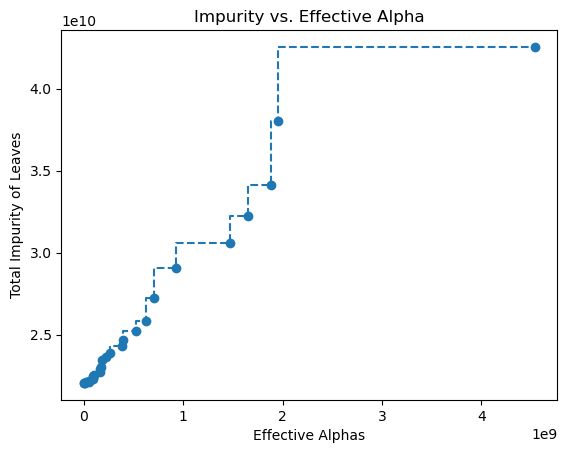

In [13]:
path = dtree.cost_complexity_pruning_path(X_train, y_train)

ccp_alphas = path.ccp_alphas
impurities = path.impurities

plt.step(ccp_alphas[:-1], impurities[:-1], '--o')
plt.title('Impurity vs. Effective Alpha')
plt.xlabel('Effective Alphas')
plt.ylabel('Total Impurity of Leaves');

### Recursive feature elimination uses an external estimator that assigns weights to features with the goal of selecting features by recursively considering smaller and smaller sets of features.

In [14]:
dtree_rfe = RFE(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_rfe.fit(X, y)
dtree_rfe_selected_features = dtree_rfe.get_support()
print('The selected features are:', list(X.columns[dtree_rfe_selected_features]))

The selected features are: ['latitude', 'longitude', 'bath', 'house_size', 'prev_sold_year']


In [15]:
X_rfe = merged_df[list(X.columns[dtree_rfe_selected_features])]
y_rfe = merged_df["price"]
X_rfe_train, X_rfe_test, y_rfe_train, y_rfe_test = train_test_split(X_rfe, y_rfe, test_size=0.3, random_state=random_state_value)

In [16]:
dtree_rfe_gscv = GridSearchCV(DecisionTreeRegressor(),param_grid={})
dtree_rfe_model = dtree_rfe_gscv.fit(X_rfe_train,y_rfe_train)
dtree_rfe_predict = dtree_rfe_model.predict(X_rfe_test)

print_more_stuff("Recursive Feature Elimination", y_rfe_test, dtree_rfe_predict, dtree_rfe_gscv)

Recursive Feature Elimination EVS = 0.397780857
Recursive Feature Elimination MSE = 36,615,458,386.624649
Recursive Feature Elimination MAE = 112,802.230878
Recursive Feature Elimination R2 = 0.397035
Recursive Feature Elimination Fit Time = 0.00556478500366211


###  Sequential Feature Selector (forward selection) adds features to form a feature subset in a greedy fashion. At each stage, this estimator chooses the best feature to add or remove based on the cross-validation score of an estimator. 

In [17]:
dtree_sfs = SequentialFeatureSelector(DecisionTreeRegressor(), n_features_to_select=num_features_to_select)
dtree_sfs.fit(X, y)
dtree_sfs_selected_features = dtree_sfs.get_support()
print('The selected features are:', list(X.columns[dtree_sfs_selected_features]))

The selected features are: ['latitude', 'bed', 'bath', 'house_size', 'prev_sold_year']


In [18]:
X_sfs = merged_df[list(X.columns[dtree_sfs_selected_features])]
y_sfs = merged_df["price"]
X_sfs_train, X_sfs_test, y_sfs_train, y_sfs_test = train_test_split(X_sfs, y_sfs, test_size=0.3, random_state=random_state_value)

In [19]:
dtree_sfs_gscv = GridSearchCV(DecisionTreeRegressor(),param_grid={})
dtree_sfs_model = dtree_sfs_gscv.fit(X_sfs_train,y_sfs_train)
dtree_sfs_predict = dtree_sfs_model.predict(X_sfs_test)
dtree_sfs_mse = mean_squared_error(y_sfs_test,dtree_sfs_predict)

print_more_stuff("Sequential Feature Selector", y_sfs_test, dtree_sfs_predict, dtree_sfs_gscv)

Sequential Feature Selector EVS = 0.258516774
Sequential Feature Selector MSE = 45,078,630,733.622131
Sequential Feature Selector MAE = 135,341.856941
Sequential Feature Selector R2 = 0.257668
Sequential Feature Selector Fit Time = 0.006261062622070312


#### Graphing the results works best when the data is provided in a DataFrame.

In [20]:
dtree_bp_predict_df = pd.DataFrame(dtree_bp_predict).reset_index()
dtree_bp_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_sfs_predict_df = pd.DataFrame(dtree_sfs_predict).reset_index()
dtree_sfs_predict_df.rename(columns={0: "prediction"},inplace=True)

dtree_rfe_predict_df = pd.DataFrame(dtree_rfe_predict).reset_index()
dtree_rfe_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

#### The predictions provided by the best parameters have the appearance of banding.  I will conduct more testing to determine if this is acceptable or if this is a case of underfitting or overfitting.

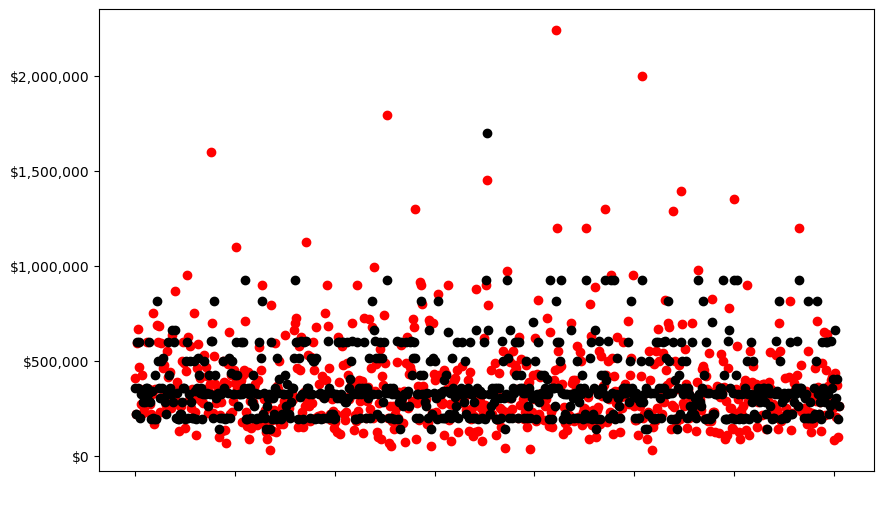

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Scatter Plot graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

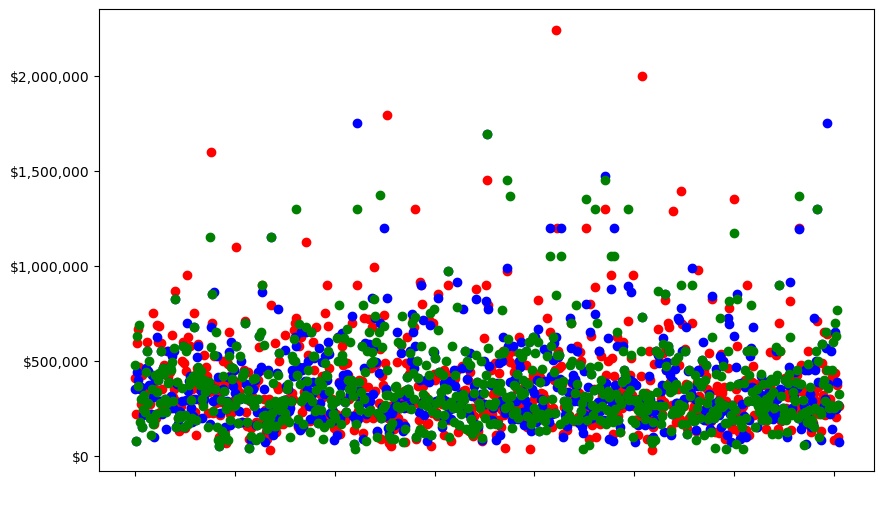

In [22]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="blue")
plt.scatter(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="green")
plt.show()

#### Sort the DataFrames by the Prediction and Price features.

In [23]:
dtree_bp_predict_df.sort_values(by='prediction', inplace=True)
dtree_bp_predict_df.reset_index(inplace=True)

dtree_sfs_predict_df.sort_values(by='prediction', inplace=True)
dtree_sfs_predict_df.reset_index(inplace=True)

dtree_rfe_predict_df.sort_values(by='prediction', inplace=True)
dtree_rfe_predict_df.reset_index(inplace=True)

y_test_df.sort_values(by='price', inplace=True)
y_test_df.reset_index(inplace=True)

#### Line graph of the results of Recursive Feature Elimination, Sequential Feature Selection, and Test Data.

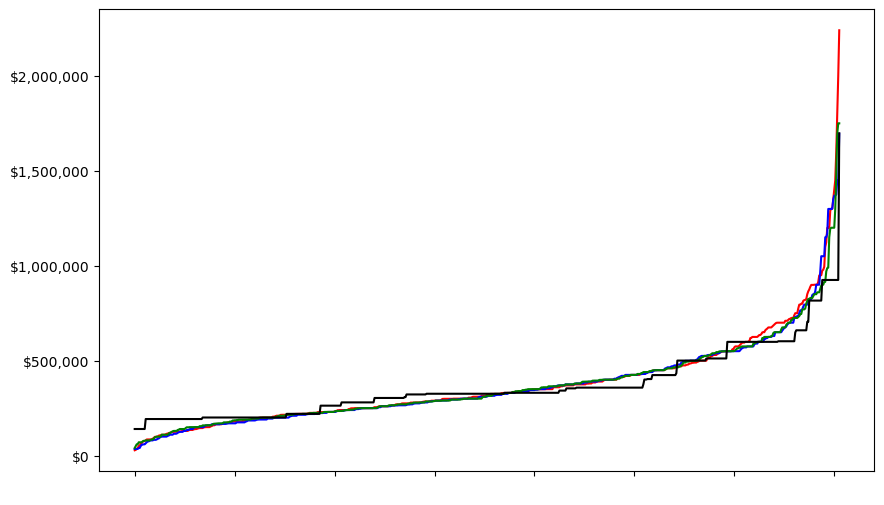

In [24]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.plot(y_test_df.index,y_test_df["price"], color="red")
plt.plot(dtree_sfs_predict_df.index,dtree_sfs_predict_df["prediction"], color="blue")
plt.plot(dtree_rfe_predict_df.index,dtree_rfe_predict_df["prediction"], color="green")
plt.plot(dtree_bp_predict_df.index,dtree_bp_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [25]:
results_dict

{'model': ['Decision Tree Best Params',
  'Recursive Feature Elimination',
  'Sequential Feature Selector'],
 'explained variance score': ['0.546833395', '0.397780857', '0.258516774'],
 'mae score': ['105,152.662220', '112,802.230878', '135,341.856941'],
 'mse score': ['27,593,804,658.024490',
  '36,615,458,386.624649',
  '45,078,630,733.622131'],
 'r2 score': ['0.545599', '0.397035', '0.257668'],
 'mean fit time': [0.003127765655517578,
  0.00556478500366211,
  0.006261062622070312]}

In [26]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Decision Tree Best Params,0.546833395,"105,152.662220","27,593,804,658.024490",0.545599,0.003128
Recursive Feature Elimination,0.397780857,"112,802.230878","36,615,458,386.624649",0.397035,0.005565
Sequential Feature Selector,0.258516774,"135,341.856941","45,078,630,733.622131",0.257668,0.006261
